In [2]:

import matplotlib.pyplot as plt
import numpy as np
from math import pi
     

import qutip as qt
from scipy import *

In [30]:
def makeJij(G, N):
    """
    Turns Jij matrix from form built in tfim.py to standard Jij where J[i][j] is the bond between spins i and j
    """
    Jij = np.zeros((N, N))
    for j in range(N // 2):
        for i in range(N):
            Jij[i][(i - j + N - 1) % N] = Jij[(i - j + N - 1) % N][i] = G[j][i]
    return Jij

In [31]:
G = [ [-1, -1, -1,  1,  1,  1,  1 , 1],[ 1 ,-1, -1, -1 ,-1, -1,  1,  1],[-1,  1, -1, -1, -1, -1 , 1 , 1],[-1 , 1,  1,  1, -1,  1,  1,  1]]
N = len(G[0])
j_map = makeJij(G,N)
gs_indeces = [63, 95, 160, 192]


si = qt.qeye(2)
sz = qt.sigmaz()


# Problem Hamiltonian
# Hp = -sum(Jij sigma_i_z sigma_j_z)


Hp = 0
for i in range(len(j_map)):
    for j in range(i,len(j_map[i])):

        sigma_i = [si if k != i else sz for k in range(N) ]
        sigma_j = [si if l != j else sz for l in range(N) ]

        Hp += j_map[i][j] * qt.tensor(sigma_i) * qt.tensor(sigma_j)   


print(Hp)
print(Hp.diag())

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]], shape=(256, 256), type='oper', dtype=CSR, isherm=True
Qobj data =
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.  -2.   0. ...   0.   0.   0.]
 [  0.   0. -14. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... -14.   0.   0.]
 [  0.   0.   0. ...   0.  -2.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
[  0.  -2. -14. -12.  -2.   0. -12.  -6.  -2.   0. -12.  -6.   0.   6.
  -6.   4.  -2.   0. -12.  -6.  -8.  -2. -14.  -4.   0.   6.  -6.   4.
  -2.   8.  -4.  10.   6.   0.  -4.  -6.   0.  -2.  -6.  -4.   0.  -2.
  -6.  -4.  -2.   0.  -4.   2.   8.   6.   2.   4.  -2.   0.  -4.   2.
   6.   8.   4.  10.   0.   6.   2.  12.   6.   0.  -4.  -6.   8.   6.
   2.   4.   0.  -2.  -6.  -4.   6.   8.   4.  10.   0.  -2.  -6.  -4.
  -2.   0.  -4.   2.  -2.   0.  -4.   2.   0.   6.   2.  12.   8.  -2.
   2.  -4.   6.   0.   4.   2.  -2.  -8.  -4.  -6.   0.  -2.   2.   4.
   6.   0.   4.   2.   0.  -2.   2.   4.   0.  -2.   2.   4.  -

In [32]:
# transverse field hamiltonian

si = qt.qeye(2)
sx = qt.sigmax()

Ht = 0
for i in range(N):
    sigma_x = [si if k != i else sx for k in range(N)]
    Ht += qt.tensor(sigma_x)


# Ht2 = 0

# for i in range(N):
#     for j in range(i+1,N):
#         sigma_x_ij = [si if k not in (i,j) else sx for k  in range(N)]
#         Ht2 += qt.tensor(sigma_x_ij)

# Ht2

In [33]:
# Iterate through annealing times

gs_probs = [[] for i in range(len(gs_indeces))]
total_prob = []

log_T = 4

taulist = np.linspace(0, (10**log_T), 10000)

# Initialize in equal superposition
psi_list = [(1/np.sqrt(2))*(qt.basis(2,0) + qt.basis(2,1)) for n in range(N)]
psi0 = qt.tensor(psi_list)


# the time-dependent hamiltonian in list-function format
args = {"t_max": max(taulist)}
h_t = [
    [-Ht, lambda t, args: (args["t_max"] - t) / args["t_max"]],
    [-Hp, lambda t, args: t / args["t_max"]],
]

# transform Hamiltonian to QobjEvo
h_t = qt.QobjEvo(h_t, args=args)

res = qt.sesolve(h_t, psi0, taulist, [], args)
final_state = [(x.real**2 + x.imag**2)[0] for x in  res.states[-1].full()]
t_p = 0
for i, gs_info in enumerate(gs_indeces):
    gs_probs[i].append(2*final_state[gs_info])
    t_p += 2*final_state[gs_info]
total_prob.append(t_p)



In [35]:
[(i,final_state[i]) for i in range(len(final_state)) if final_state[i] > 0.01]
gs_probs

[[0.4999999967154333],
 [0.4999999967154436],
 [0.4999999967151727],
 [0.4999999967152002]]

In [34]:
evals, ekets = Hp.eigenstates(eigvals=1)
ekets[0].full().real.flatten()
# print([i for i in range(len(ekets))])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

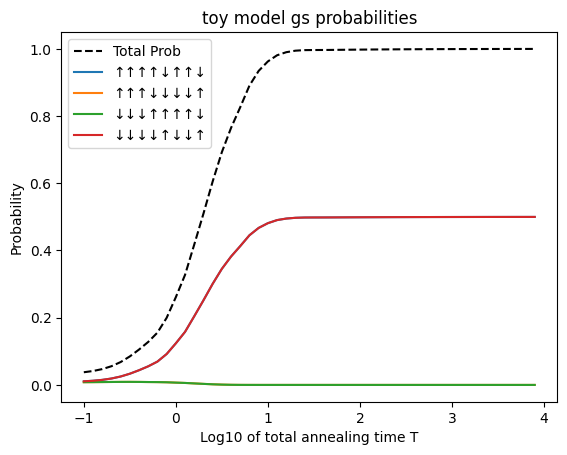

In [13]:
unicode_map = {"0": "\u2191", "1": "\u2193"}

plt.plot([i for i in np.arange(-1,4,0.1)], total_prob, color= "black", linestyle='--', label = "Total Prob")

for i,gs in enumerate(gs_indeces):
    plt.plot([i for i in np.arange(-1,4,0.1)], gs_probs[i], label = "".join([unicode_map[c] for c in bin(gs)[2:].zfill(N)]))


plt.title("toy model gs probabilities")
plt.xlabel("Log10 of total annealing time T")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [162]:
#
# callback function for each time-step
#

M = 8
evals_mat = np.zeros((len(taulist), M))
P_mat = np.zeros((len(taulist), M))

idx = [0]

def process_rho(tau, psi):

    # evaluate the Hamiltonian with gradually switched on interaction
    H = h_t(tau)

    # find the M lowest eigenvalues of the system
    evals, ekets = H.eigenstates(eigvals=M)

    evals_mat[idx[0], :] = np.real(evals)

    # find the overlap between the eigenstates and psi
    for n, eket in enumerate(ekets):
        # print(eket.dag())
        # print((abs((eket.dag() * psi)) ** 2).data)
        P_mat[idx[0], n] = float(((abs((eket.dag() * psi)) ** 2).data or [0])[0])
        # P_mat[idx[0], n] = np.abs(np.dot(eket.full().flatten(),psi.full().flatten()))

    idx[0] += 1

In [163]:
# Check final state fidelity with true gs

annealing_time_log10 = 4


taulist = np.linspace(0, (10**annealing_time_log10), 10000)

# Initialize in equal superposition
psi_list = [(1/np.sqrt(2))*(basis(2,0) + basis(2,1)) for n in range(N)]
psi0 = tensor(psi_list)


# the time-dependent hamiltonian in list-function format
args = {"t_max": max(taulist)}
h_t = [
    [-Ht, lambda t, args: (args["t_max"] - t) / args["t_max"]],
    [-Hp, lambda t, args: t / args["t_max"]],
]

# transform Hamiltonian to QobjEvo
h_t = QobjEvo(h_t, args=args)

mesolve(h_t, psi0, taulist, [], process_rho, args)

# final_state = res.states[-1] 

# evals, ekets = h_t((10**annealing_time_log10)-0.1).eigenstates(eigvals=1)


/var/folders/84/h0vjvdyd5jsfdwfh08421q980000gn/T/ipykernel_95437/1736075728.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  P_mat[idx[0], n] = float(((abs((eket.dag() * psi)) ** 2).data or [0])[0])
/var/folders/84/h0vjvdyd5jsfdwfh08421q980000gn/T/ipykernel_95437/1736075728.py:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  P_mat[idx[0], n] = float(((abs((eket.dag() * psi)) ** 2).data or [0])[0])


Result object with sesolve data.
--------------------------------
expect = True
num_expect = 1, num_collapse = 0

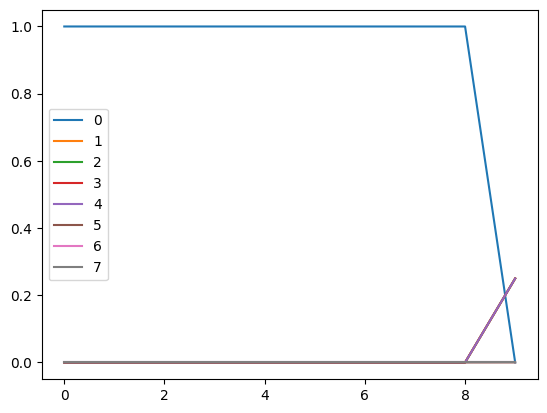

In [165]:
for ni,egsf in enumerate(P_mat.T):
    plt.plot(egsf[9990:], label = ni)

# plt.xscale('log')
plt.legend()
plt.show()


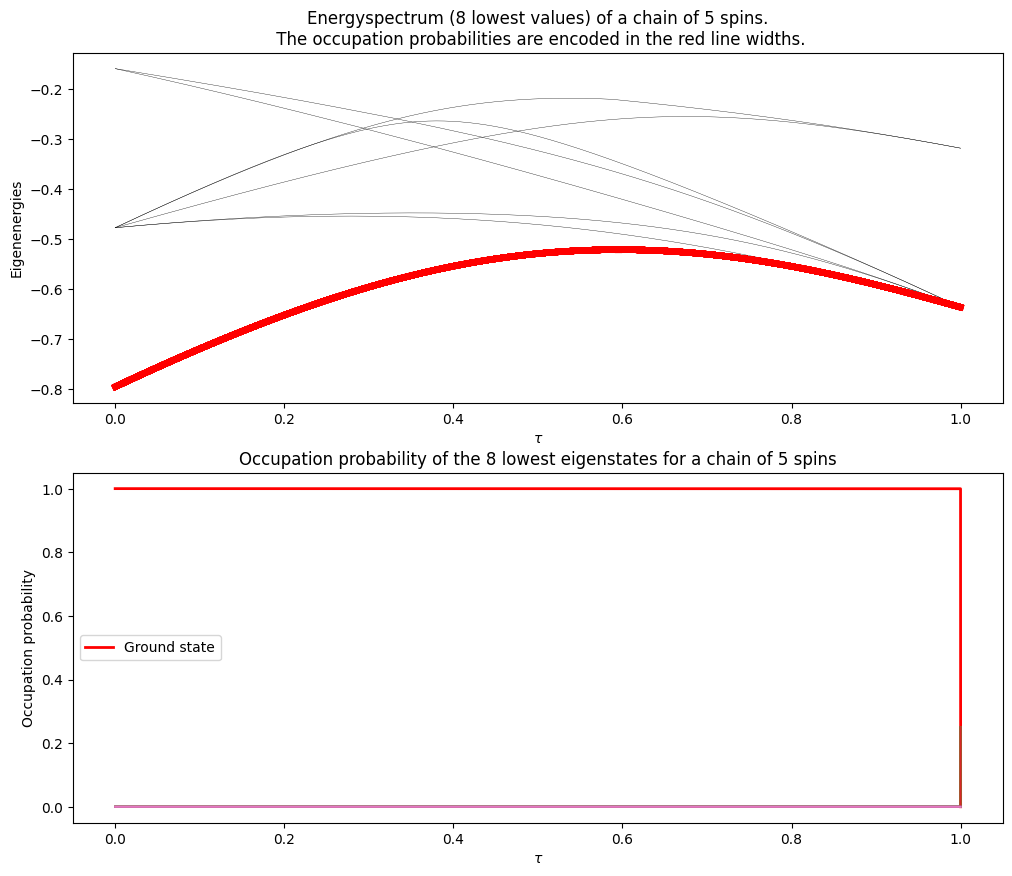

In [128]:
# rc('font', family='serif')
# rc('font', size='10')

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

#
# plot the energy eigenvalues
#

# first draw thin lines outlining the energy spectrum
for n in range(len(evals_mat[0, :])):
    ls, lw = ("b", 1) if n == 0 else ("k", 0.25)
    axes[0].plot(taulist / max(taulist), evals_mat[:, n] / (2 * np.pi),
                 ls, lw=lw)

# second, draw line that encode the occupation probability of each state in
# its linewidth. thicker line => high occupation probability.
for idx in range(len(taulist) - 1):
    for n in range(len(P_mat[0, :])):
        lw = 0.5 + 4 * P_mat[idx, n]
        if lw > 0.55:
            axes[0].plot(
                np.array([taulist[idx], taulist[idx + 1]]) / (10**annealing_time_log10),
                np.array([evals_mat[idx, n],
                          evals_mat[idx + 1, n]]) / (2 * np.pi),
                "r",
                linewidth=lw,
            )

axes[0].set_xlabel(r"$\tau$")
axes[0].set_ylabel("Eigenenergies")
axes[0].set_title(
    "Energyspectrum (%d lowest values) of a chain of %d spins.\n " % (M, N)
    + "The occupation probabilities are encoded in the red line widths."
)

#
# plot the occupation probabilities for the few lowest eigenstates
#
for n in range(len(P_mat[0, :])):
    if n == 0:
        axes[1].plot(taulist / max(taulist), 0 + P_mat[:, n], "r", linewidth=2)
    else:
        axes[1].plot(taulist / max(taulist), 0 + P_mat[:, n])

axes[1].set_xlabel(r"$\tau$")
axes[1].set_ylabel("Occupation probability")
axes[1].set_title(
    "Occupation probability of the %d lowest " % M
    + "eigenstates for a chain of %d spins" % N
)
axes[1].legend(("Ground state",));

In [116]:
P_mat[idx[0],0]

0.9999999999999998

In [21]:

# [9, 30, 225, 246] hamming dist 4
[0.9997613344767595]
[[0.49988066723837765], [6.3208967064871105e-15], [6.3208963739116824e-15], [0.49988066723836916]]

#

[[0.49988066723837765],
 [6.3208967064871105e-15],
 [6.3208963739116824e-15],
 [0.49988066723836916]]

In [ ]:
# [63, 95, 160, 192] hamming dist 2